In [3]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as k
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_columns', None)  # show all columns
GPUs = tf.config.list_physical_devices('GPU')
if GPUs is None or len(GPUs) == 0:
    print("WARNING: No GPU, all there is is:")
    for device in tf.config.list_physical_devices():
        print(f'- {device}')
else:
    for gpu in GPUs:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("Initialized", gpu)

Initialized PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
def postpad_to(sequence, to):
    return k.preprocessing.sequence.pad_sequences(sequence, to, padding='post', truncating='post')

def map_text(X):
    if X[-1] == '/':
        X = X[:-1]
    return X

#
# data = pd.concat([
#     pd.read_csv('../data/mixed.csv', index_col=False),
#     pd.DataFrame({
#         'url': ['http://' + map_text(X) for X in open('../data/MalwareURLExport.csv', 'r').readlines()],
#         'type': 1
#     }).reset_index(drop=True).sample(
#         n=50000,
#         replace=False,
#         random_state=42
#     ),
#     pd.read_csv('../data/kaggle_data_clean.csv', index_col=0).reset_index(drop=True)
# ]).drop_duplicates(subset=['url'])
#
# data.to_csv('../data/cleaned-and-combined.csv', index=False)
data = pd.read_csv('../data/cleaned-and-combined.csv', index_col=False)

data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
data_train, data_validation = train_test_split(
    data,
    test_size=0.3,
    stratify=data['type'],
    shuffle=True,
    random_state=42
)

In [5]:
data.groupby('type').aggregate('count'), data_train.groupby('type').aggregate('count'), data_validation.groupby('type').aggregate('count'),

(         url
 type        
 0     380128
 1     133956,
          url
 type        
 0     266089
 1      93769,
          url
 type        
 0     114039
 1      40187)

In [6]:
to_characters = k.preprocessing.text.Tokenizer(char_level=True, oov_token='<OOV>', filters='\t\n')
to_characters.fit_on_texts(data_train['url'])
word_vectorizer = CountVectorizer(
    stop_words=None,
    min_df=5,
    token_pattern=r'&\w+;|[:/&?=.\[\]\\]|%\w{2}|[-_\w\d]+',
    analyzer='word',
    max_features=500
)
word_vectorizer.fit(data_train['url'])
word_tokenizer = word_vectorizer.build_tokenizer()

LW = len(word_vectorizer.vocabulary_)
LC = len(to_characters.word_counts)

print('Word vocab size:', LW)
print('Char vocab size:', LC)

# def create_dataset(df):
#     # wv = tf.constant(postpad_to(word_vectorizer.texts_to_sequences(df['url']), 200), name='word')
#     wv = tf.constant(postpad_to(
#         df['url'].map(lambda url: [word_vectorizer.vocabulary_.get(a, -1)+2 for a in word_tokenizer(url)])
#         , 200), name='word')
#     cv = tf.constant(postpad_to(to_characters.texts_to_sequences(df['url']), 200), name='char')
#     targets = tf.one_hot(df['type'], depth=2)
#
#     ds = tf.data.Dataset.from_tensor_slices(((wv, cv), targets)).shuffle(10000).batch(256)
#     return ds

Word vocab size: 500
Char vocab size: 157


In [7]:
def create_dataset(df: pd.DataFrame):
    # wv = tf.constant(postpad_to(word_vectorizer.texts_to_sequences(df['url']), 200), name='word')
    def gen():
        for row in df.iterrows():
            url=row[1].url
            _type = row[1].type

            wv = tf.constant(postpad_to(
                [ [word_vectorizer.vocabulary_.get(a, -1)+2 for a in word_tokenizer(url)] ]
                , 200), name='word')
            cv = tf.constant(postpad_to(to_characters.texts_to_sequences([url]), 200), name='char')
            target = _type  # tf.one_hot([_type], depth=2)

            yield {'word': tf.squeeze(wv), 'char': tf.squeeze(cv)}, tf.squeeze(target)

    ds = tf.data.Dataset.from_generator(gen, output_types=(
        {'word': tf.float64, 'char': tf.float64}, tf.int32
    ), output_shapes=(
        {'word': tf.TensorShape([200]), 'char': tf.TensorShape([200])}, tf.TensorShape([])
    )).shuffle(10000).prefetch(10000) #.batch(15*1024)
    return ds
#         {'word': tf.TensorShape([200]), 'char': tf.TensorShape([200])}, tf.TensorShape([2])

dataset_train = create_dataset(data_train)
dataset_validation = create_dataset(data_validation)

print('Train:', dataset_train.element_spec, '\nValid:', dataset_validation.element_spec)

Train: ({'word': TensorSpec(shape=(200,), dtype=tf.float64, name=None), 'char': TensorSpec(shape=(200,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None)) 
Valid: ({'word': TensorSpec(shape=(200,), dtype=tf.float64, name=None), 'char': TensorSpec(shape=(200,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 16)      2544        char[0][0]                       
__________________________________________________________________________________________________
char_conv_3 (Conv1D)            (None, 200, 32)      1568        embedding[0][0]                  
__________________________________________________________________________________________________
char_conv_5 (Conv1D)            (None, 200, 32)      2592        embedding[0][0]                  
______________________________________________________________________________________________

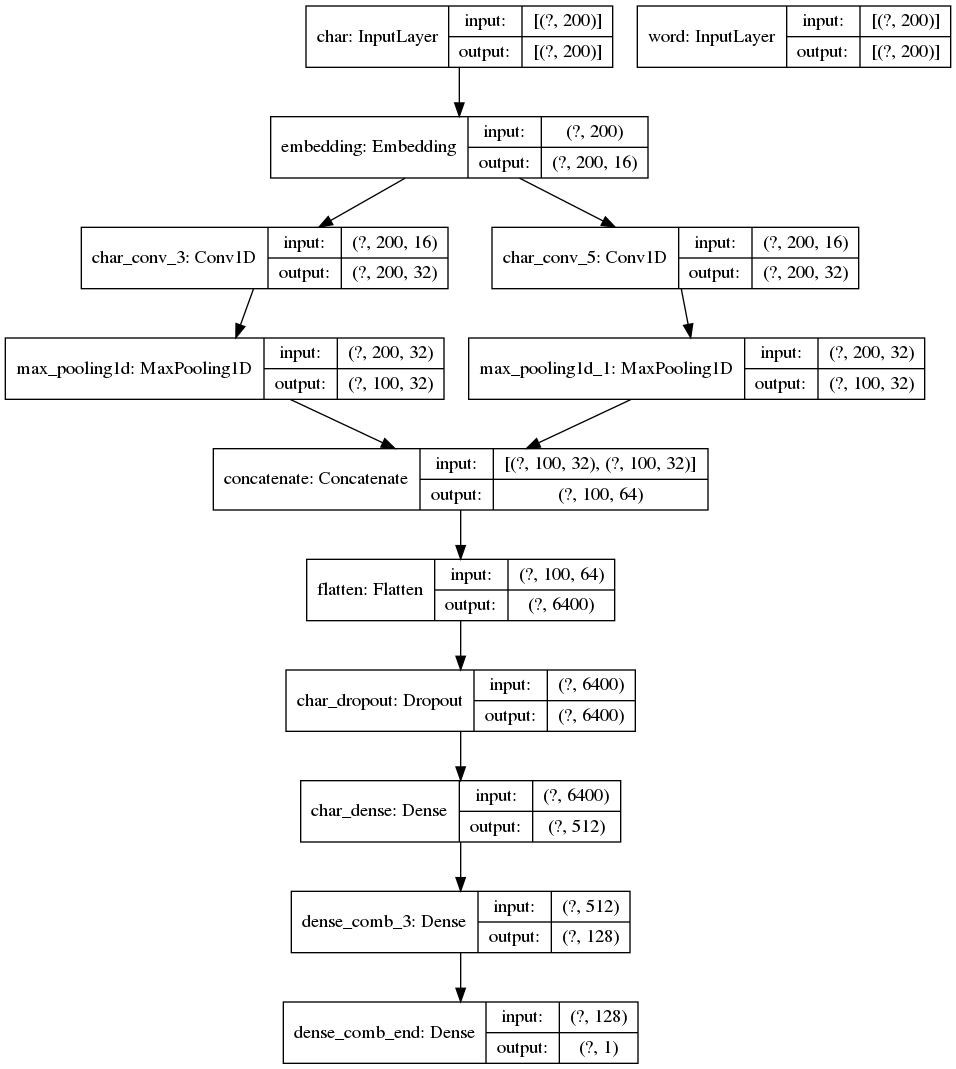

In [8]:
def create_conv_subnet(input_layer, conv_kernel_sizes, prefix=''):
    convolutions = list()
    for kernel_size in conv_kernel_sizes:
        x = k.layers.Conv1D(
            # filters=256,
            filters=32,
            kernel_size=kernel_size,
            padding='same',
            activation='relu',
            name=f'{prefix}_conv_{kernel_size}'
        )(input_layer)
        # x = k.layers.Activation('relu')(x)
        x = k.layers.MaxPool1D()(x)
        convolutions.append(x)

    x = k.layers.concatenate(convolutions, axis=2)
    x = k.layers.Flatten()(x)
    x = k.layers.Dropout(0.5, name=f'{prefix}_dropout')(x)
    x = k.layers.Dense(512, name=f'{prefix}_dense', activation='relu')(x)
    # x = k.layers.Dense(128, name=f'{prefix}_dense')(x)
    # x = k.layers.Dense(32, name=f'{prefix}_dense')(x)
    return x

def create_url_net(input_length, emb_dim, conv_kernel_sizes):
    # word_input = k.layers.Input(shape=[input_length, LW], name='word')
    # char_input = k.layers.Input(shape=[input_length, LC], name='char')
    word_input = k.layers.Input(shape=[input_length], name='word')
    char_input = k.layers.Input(shape=[input_length], name='char')

    character_subnet = create_conv_subnet(
        k.layers.Embedding(2+LC, emb_dim, mask_zero=True)(char_input),
        conv_kernel_sizes,
        'char'
    )

    # word_subnet = create_conv_subnet(
    #     k.layers.Embedding(2+LW, emb_dim, mask_zero=True)(word_input),
    #     conv_kernel_sizes,
    #     'word'
    # )

    # x = k.layers.concatenate([character_subnet, word_subnet])
    x = character_subnet
    # x = k.layers.Dense(512, activation='relu', name='dense_comb_1')(x)
    # x = k.layers.Dense(256, activation='relu', name='dense_comb_2')(x)
    x = k.layers.Dense(128, activation='relu', name='dense_comb_3')(x)
#     x = k.layers.Dense(2, activation='softmax', name='dense_comb_end')(x)
    x = k.layers.Dense(1, activation='sigmoid', name='dense_comb_end')(x)

    model = k.models.Model(inputs=[word_input, char_input], outputs=[x])
    # model = k.models.Model(inputs=[char_input], outputs=[x])
    return model

model = create_url_net(
    input_length=200,
    # emb_dim=32,
    emb_dim=16,
    # conv_kernel_sizes=[3,4,5,6]
    conv_kernel_sizes=[3,5]
)
model.compile(
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']#, k.metrics.Precision(), k.metrics.Recall()]
)
#     loss='binary_crossentropy',
model.summary()
k.utils.plot_model(model, show_shapes=True)

In [9]:
bs=256*8

model.fit(
    dataset_train.batch(bs),
    epochs=100,
    validation_data=dataset_validation.batch(bs),
    callbacks=[
        k.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        k.callbacks.ModelCheckpoint('./checkpoints', verbose=0)
    ],
)

In [8]:
model.save('full_convolution')

INFO:tensorflow:Assets written to: full_convolution.hd5/assets


In [12]:
model = k.models.load_model('full_convolution')

In [13]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

In [27]:
np_validation = np.array([*dataset_validation.as_numpy_iterator()])
X_validation, y_validation = np_validation.T

In [28]:
X_validation2 = np.array([(item['word'],item['char']) for item in X_validation])
X_validation2.shape

(154226, 2, 200)

In [47]:
new_validation = tf.data.Dataset.from_tensor_slices(((X_validation2[:,0,:], X_validation2[:,1,:]), )).batch(bs)
new_validation

<BatchDataset shapes: (((None, 200), (None, 200)),), types: ((tf.float64, tf.float64),)>

In [56]:
y_hat = model.predict(new_validation).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_validation.astype('int32'), y_hat)

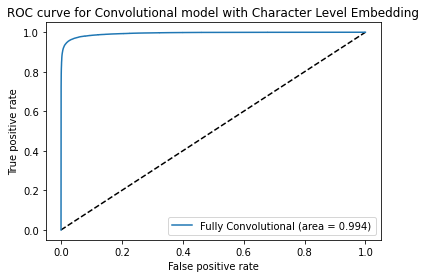

In [61]:
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Fully Convolutional (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Convolutional model with Character Level Embedding')
plt.legend(loc='best')
plt.savefig('../plots/full_convolution_roc.pdf')
plt.show()

In [38]:
row = data.loc[16]
url = row['url']
tokens = word_tokenizer(url)
{a: word_vectorizer.vocabulary_.get(a, -1)+2 for a in tokens}

{'http': 300,
 ':': 152,
 '/': 95,
 'ilike': 1,
 '.': 94,
 'com': 226,
 'artist': 183,
 'Earl': 1,
 'Thomas': 1,
 'Conley': 1,
 'track': 1,
 'Too': 1,
 'Many': 1,
 'Times': 1,
 '%28': 8,
 'Duet': 1,
 'With': 1,
 'Anita': 1,
 'Pointer': 1,
 '%29': 9}

In [40]:
word_vectorizer.vocabulary_

{'http': 298,
 ':': 150,
 '/': 93,
 '.': 92,
 'com': 224,
 'us': 468,
 's': 410,
 '2': 121,
 'org': 369,
 'about': 158,
 'shtml': 419,
 'thenextweb': 445,
 'media': 338,
 '2014': 128,
 '10': 105,
 '21': 130,
 'answers': 170,
 'yahoo': 494,
 'question': 396,
 'index': 311,
 '?': 152,
 'qid': 394,
 '=': 151,
 'update': 464,
 'ru': 409,
 'html': 297,
 'video': 473,
 'mylife': 348,
 'net': 352,
 'news': 355,
 'aspx': 184,
 'article': 179,
 '&': 89,
 'wp-content': 488,
 'plugins': 386,
 'twitter': 459,
 'home': 295,
 'status': 431,
 '%e3': 80,
 '%83': 20,
 '%8c': 29,
 '%81': 18,
 '%91': 33,
 '%82': 19,
 '%8b': 28,
 '%ef': 88,
 '%bc': 68,
 '%80': 17,
 '%90': 32,
 '%e4': 81,
 '%ba': 66,
 '%e5': 82,
 '%a6': 46,
 '%bb': 67,
 '%e7': 84,
 '%86': 23,
 '%9f': 40,
 '%a5': 45,
 '%b3': 59,
 '%3a': 12,
 '%2f': 11,
 't': 434,
 '%b5': 61,
 '%b8': 64,
 '%ab': 51,
 '%84': 21,
 '%89': 26,
 '%23': 2,
 'cn': 222,
 'uk': 463,
 'wiki': 482,
 'images': 306,
 'all': 167,
 'encyclopedia': 258,
 'php': 380,
 '&amp;